## Part I

1. Big data pipeline in AWS 

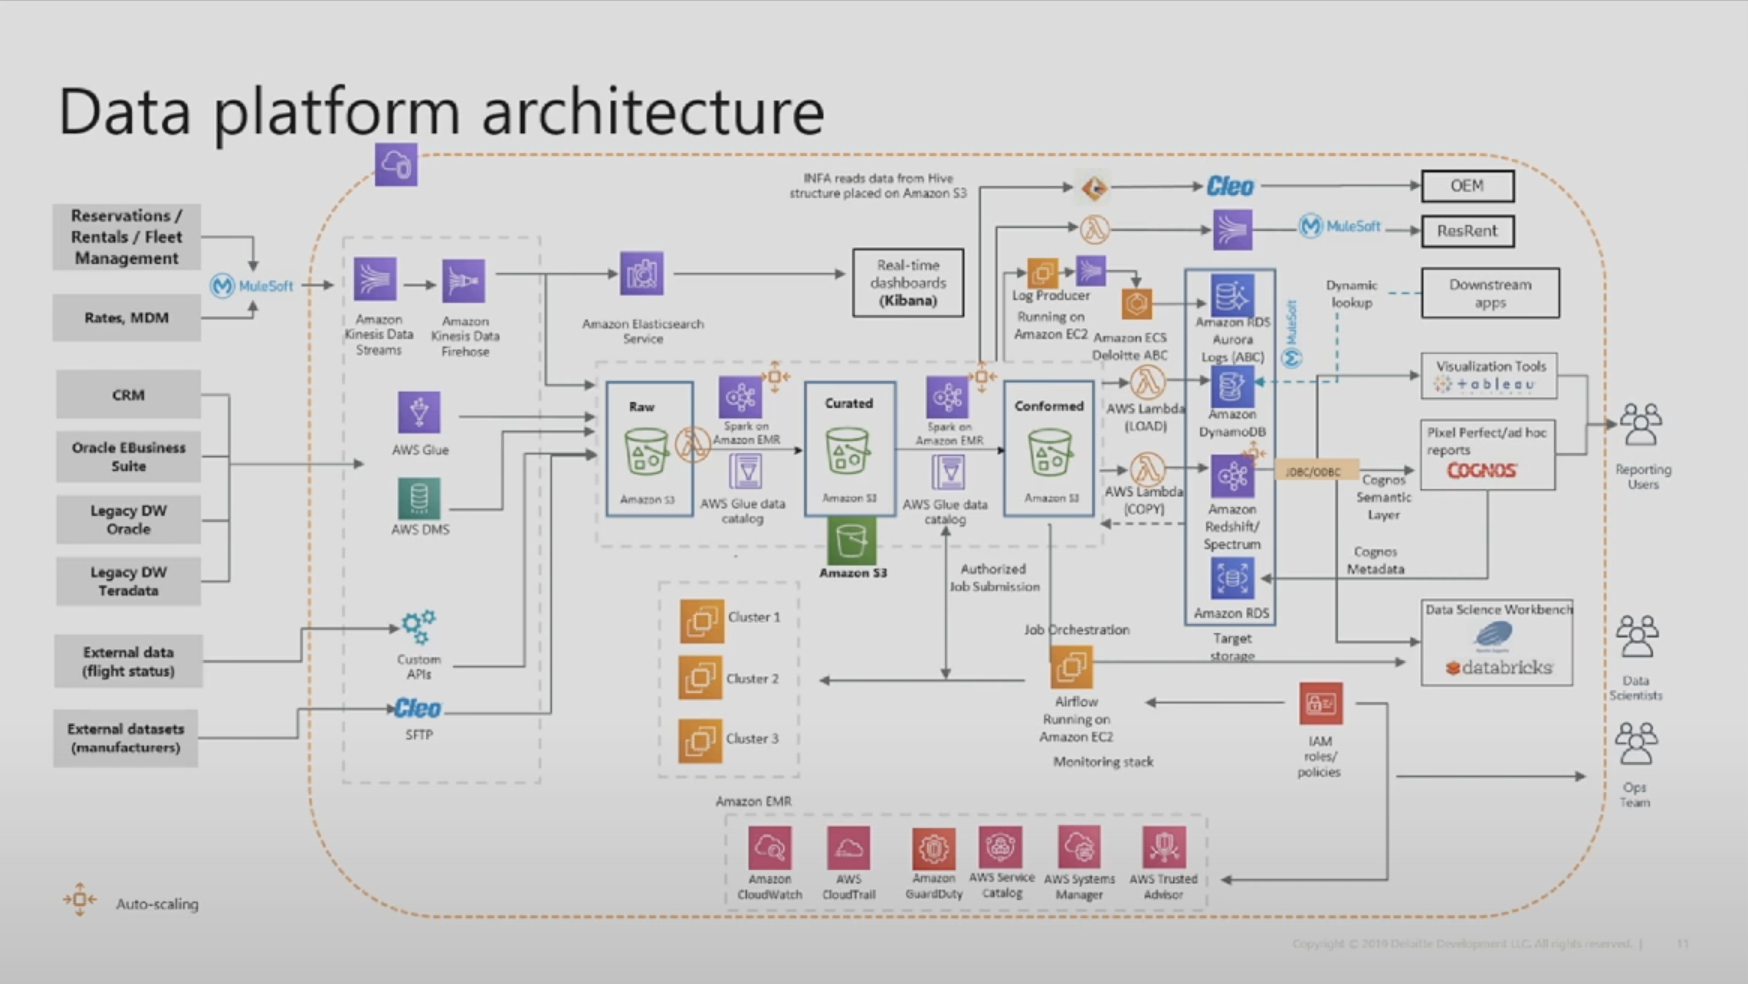


## Part II

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
con = sqlite3.connect('northwind.sqlite')
q = '''
    SELECT name
    FROM sqlite_schema
    WHERE type = "table";
    '''

df = pd.read_sql_query(q, con)
df

,name
0,Categories
1,sqlite_sequence
2,CustomerCustomerDemo
3,CustomerDemographics
4,Customers
5,Employees
6,EmployeeTerritories
7,Order Details
8,Orders
9,Products


In [99]:
orders_per_empl = pd.merge(
  left = pd.read_sql("Select OrderID, EmployeeID from Orders", con),
  right = pd.read_sql("Select DISTINCT EmployeeID, LastName from Employees", con),
  how = "left",
  on = "EmployeeID")

#### Overall number of orders per employee

In [100]:
orders_per_empl = orders_per_empl.groupby(['EmployeeID', 'LastName']).count()
orders_per_empl = orders_per_empl.reset_index()
orders_per_empl.columns = ['EmployeeID', 'LastName', 'orders_count']
orders_per_empl.sort_values('orders_count', axis=0, ascending=False, inplace=True)
orders_per_empl

,EmployeeID,LastName,orders_count
3,4,Peacock,156
2,3,Leverling,127
0,1,Davolio,123
7,8,Callahan,104
1,2,Fuller,96
6,7,King,72
5,6,Suyama,67
8,9,Dodsworth,43
4,5,Buchanan,42


#### Order numbers per employee across months

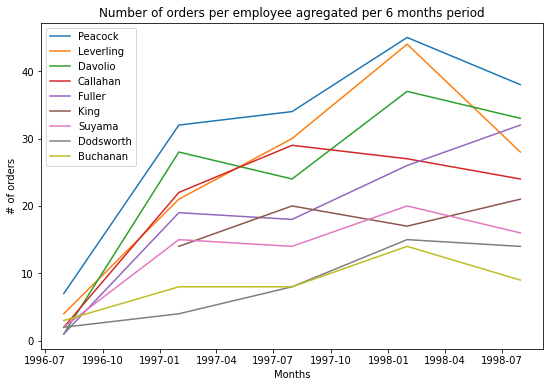

In [143]:
orders_by_date = pd.merge(
  left = pd.read_sql("Select EmployeeID, OrderDate from Orders", con),
  right = pd.read_sql("Select EmployeeID, LastName from Employees", con),
  how = "left",
  on = "EmployeeID")


orders_by_date['OrderDate'] = pd.to_datetime(orders_by_date['OrderDate'])
orders_by_date = orders_by_date.groupby(['LastName', pd.Grouper(key='OrderDate', freq='6M')]).count()

orders_by_date = orders_by_date.reset_index()
orders_by_date.columns = ['LastName', 'OrderDate', 'orders_count']
orders_by_date


#df.groupby(pd.Grouper(key='Date', freq='2Y')).sum()
empl_names = orders_per_empl['LastName'].to_list()

plt.rcParams["figure.figsize"]= (9,6)
for i in range(len(empl_names)):
    tmp = orders_by_date.loc[ (orders_by_date["LastName"] == empl_names[i])]
    plt.plot(tmp.OrderDate, tmp.orders_count, label = empl_names[i])
plt.title("Number of orders per employee agregated per 6 months period")
plt.xlabel("Months")
plt.ylabel("# of orders")
plt.legend()
plt.show()
plt.close()    

#### Orders per category

In [251]:
q = '''
    select Orders.EmployeeID, Employees.LastName, Orders.OrderID, [Order Details].ProductID, Products.CategoryID, Categories.CategoryName
    from Orders
    left join Employees on Employees.EmployeeID = Orders.EmployeeID
    left join [Order Details] on Orders.OrderID = [Order Details].OrderID
    left join Products on [Order Details].ProductID = Products.ProductID
    left join Categories on Products.CategoryID = Categories.CategoryID
    '''
df = pd.read_sql_query(q, con)
data = df.loc[:, ('LastName','CategoryName', 'OrderID')].groupby(['LastName', 'CategoryName']).count()
data = data.reset_index()
data.columns = ['LastName', 'CategoryName', 'OrderNumWithCategory']

Text(10.059355709876549, 0.5, 'Number of orders per category')

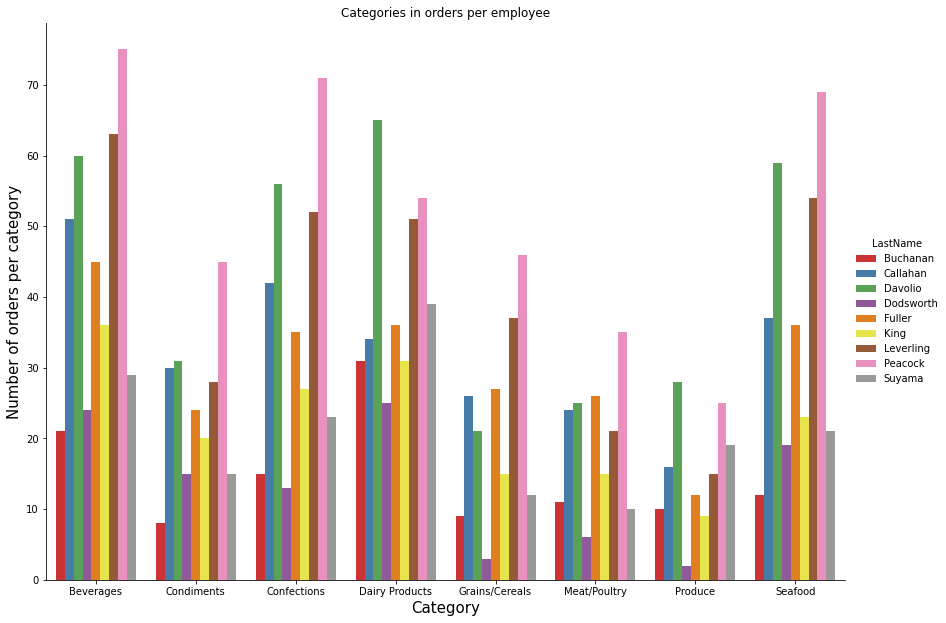

In [263]:
import seaborn as sns

g = sns.catplot(x='CategoryName', y='OrderNumWithCategory', data=data, kind='bar', 
                hue='LastName', 
                legend=True,
                palette='Set1',
                height=8.27, aspect=11.7/8.27).set(title='Categories in orders per employee')
plt.xlabel("Category", size=15)
plt.ylabel("Number of orders per category", size=15)

Text(10.757465277777783, 0.5, 'Number of orders per category')

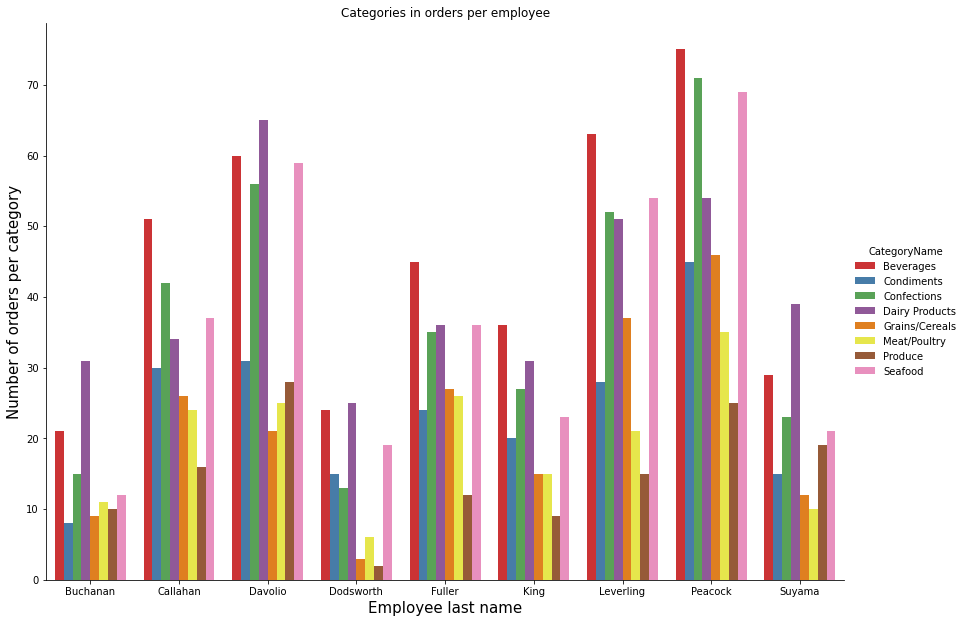

In [262]:
g = sns.catplot(x='LastName', y='OrderNumWithCategory', data=data, kind='bar', 
                hue='CategoryName', 
                legend=True,
                palette='Set1',
                height=8.27, aspect=11.7/8.27).set(title='Categories in orders per employee')
plt.xlabel("Employee last name", size=15)
plt.ylabel("Number of orders per category", size=15)

#### Employees vs Customers

In [270]:
q = '''
    select Orders.EmployeeID, Employees.LastName, Customers.CompanyName
    from Orders
    left join Customers on Orders.CustomerID = Customers.CustomerID
    left join Employees on Employees.EmployeeID = Orders.EmployeeID
    '''

df = pd.read_sql_query(q, con)
pd.crosstab (df.LastName, df.CompanyName)

CompanyName,Alfreds Futterkiste,Ana Trujillo Emparedados y helados,Antonio Moreno TaquerÃ­a,Around the Horn,B's Beverages,Berglunds snabbkÃ¶p,Blauer See Delikatessen,Blondesddsl pÃ¨re et fils,Bon app',Bottom-Dollar Markets,...,TradiÃ§Ã£o Hipermercados,Trail's Head Gourmet Provisioners,Vaffeljernet,Victuailles en stock,Vins et alcools Chevalier,Wartian Herkku,Wellington Importadora,White Clover Markets,Wilman Kala,Wolski Zajazd
LastName,,,,,,,,,,,,,,,,,,,,,
Buchanan,0,0,0,0,0,2,0,1,1,0,...,0,0,0,0,1,2,0,1,0,1
Callahan,0,0,0,1,0,2,1,1,2,0,...,0,0,2,2,0,4,0,2,0,1
Davolio,2,0,1,3,1,4,0,0,3,2,...,2,0,4,2,0,1,1,1,1,2
Dodsworth,0,0,0,2,1,2,3,1,2,1,...,0,1,0,0,0,1,1,0,0,0
Fuller,0,0,0,0,1,1,0,1,1,2,...,0,0,1,1,2,3,0,1,3,0
King,0,1,2,0,1,0,0,0,1,1,...,1,0,1,0,0,0,2,2,1,0
Leverling,1,2,3,2,2,6,1,2,3,4,...,1,0,1,3,1,1,3,3,1,0
Peacock,2,1,1,4,2,1,1,3,4,2,...,2,1,1,2,0,2,2,4,1,2
Suyama,1,0,0,1,2,0,1,2,0,2,...,0,1,1,0,1,1,0,0,0,1
